In this notebook, we examine the relationship between a player's pass volume and completion percentage 

In [2]:
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/";

comp_url = base_url + "matches/{}/{}.json";

match_url = base_url + "events/{}.json";

In [5]:
def parse_data(comp_id, season_id):
    '''
    Parameters:
            comp_id (int): Competition id for Stats_Bomb database
            season_id (int): Season id for Stats_Bomb database

    Returns:
            events_df (arr): DataFrame containing all shots in a certain competition and
            season 
    '''
    ## Get matches from url ##
    matches = requests.get(url=comp_url.format(comp_id, season_id)).json();
    
    ## Obtain match_ids ##
    match_ids = [m['match_id'] for m in matches];
    
    all_events = [];
    
    ## Iterate through, show progress bar ##
    for match_id in tqdm(match_ids):
        
        ## Get events ##
        events = requests.get(url=match_url.format(match_id)).json();
        
        ## Get passing data ##
        passes = [x for x in events if x['type']['name'] == "Pass"];
        
        for a in passes:
            attributes = {
                "player_id": a['player']['id'],
                ## StatsBomb only presents an outcome key on event objects that are incomplete ##
                "outcome":0 if 'outcome' in a['pass'].keys() else 1,
            }
            all_events.append(attributes)
    
    events_df = pd.DataFrame(all_events)
    
    return events_df

In [6]:
comp_id = 43
season_id = 3

df = parse_data(comp_id, season_id)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:28<00:00,  2.23it/s]


In [7]:
## Show the first few entries ## 
df.head(10)

,player_id,outcome
0,4319,1
1,5259,0
2,5263,0
3,5255,0
4,5255,1
5,5259,1
6,5249,1
7,5255,1
8,5249,1
9,5260,1


In the above, the outcome of '0' denotes a pass that was not completed, while '1' indicates a successful pass. We may then compute the total number of passes for the players who completed passes, and compute the percentage of passes completed

In [8]:
total_passes = df.groupby('player_id')['outcome'].sum();

percentage = df.groupby('player_id')['outcome'].mean();

Text(0.5, 1.0, 'Total Percentage of Passes Completed by each player, for the number of passes')

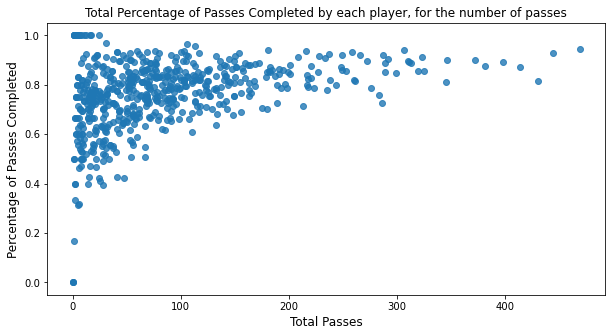

In [9]:
fig, ax = plt.subplots(figsize=(10,5));

ax.scatter(total_passes,percentage, alpha=0.8)
ax.set_xlabel("Total Passes", fontsize=12)
ax.set_ylabel("Percentage of Passes Completed", fontsize=12)
ax.set_title("Total Percentage of Passes Completed by each player, for the number of passes")

In [14]:
model = LinearRegression()

fit = model.fit([[x] for x in total_passes], percentage)

## Get form of y = mx + c ##
grad = fit.coef_[0]
inter = fit.intercept_

print(f"Coefficients: {grad:.7f}, Intercept: {inter:.2f}")

Coefficients: 0.0006321, Intercept: 0.71


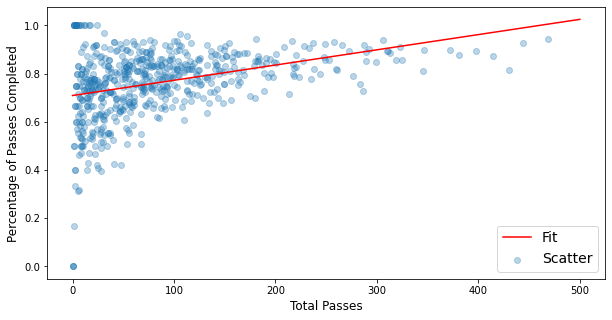

In [25]:
## Next, build the line to superpose on the scatter plot ## 
xfit = [0, 500];
yfit = model.predict([[x] for x in xfit]);

## Now, let's plot it ##
fig, ax = plt.subplots(figsize=(10,5));

ax.scatter(total_passes, percentage, alpha=0.3, label="Scatter");
ax.plot(xfit, yfit, 'r', label="Fit");

ax.set_xlabel("Total Passes", fontsize=12);
ax.set_ylabel("Percentage of Passes Completed", fontsize=12);

ax.legend(prop={'size':14})
plt.show()

This is my interpretation of the small task we've done here. It's clear the percentage of passes completed for the number of passes made by a player cannot be approximate by a linear regression line. Football is a more dynamical system, with more complicated Statistics at play. How